# Emotion Detection from Facial Images (CK+ Dataset)
This notebook demonstrates how to train and evaluate a CNN model to classify facial expressions using the CK+ dataset.

## 1. Setup Environment
Ensure you have Python 3.8+ and the following libraries installed.

In [22]:
%pip install torch torchvision matplotlib scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


## 2. Import Required Libraries
We begin by importing PyTorch, torchvision, and utility libraries.

In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## 3. Define Transformations and Load the CK+ Dataset

In [24]:
dataset_path = r"C:\Users\Admin\Desktop\Emotion Detection from facial images\CK+48"  # Change this
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4. Define the CNN Model
A simple convolutional neural network for emotion classification.

In [25]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*12*12, 128), nn.ReLU(),
            nn.Linear(128, len(class_names))
        )
    def forward(self, x):
        return self.net(x)

model = EmotionCNN().to(device)

## 5. Train the Model

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 1.5223
Epoch 2/10, Loss: 0.7362
Epoch 3/10, Loss: 0.3661
Epoch 4/10, Loss: 0.2159
Epoch 5/10, Loss: 0.1255
Epoch 6/10, Loss: 0.0716
Epoch 7/10, Loss: 0.0534
Epoch 8/10, Loss: 0.0465
Epoch 9/10, Loss: 0.0379
Epoch 10/10, Loss: 0.0221


In [27]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(f"Validation Accuracy: {accuracy_score(y_true, y_pred):.2%}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

Validation Accuracy: 98.98%

Classification Report:
               precision    recall  f1-score   support

       anger       0.97      0.97      0.97        33
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       1.00      1.00      1.00        43
     sadness       0.94      1.00      0.97        16
    surprise       1.00      1.00      1.00        45

    accuracy                           0.99       197
   macro avg       0.99      0.99      0.99       197
weighted avg       0.99      0.99      0.99       197



## 6. Confusion Matrix
Visualizing the model’s predictions across all classes.

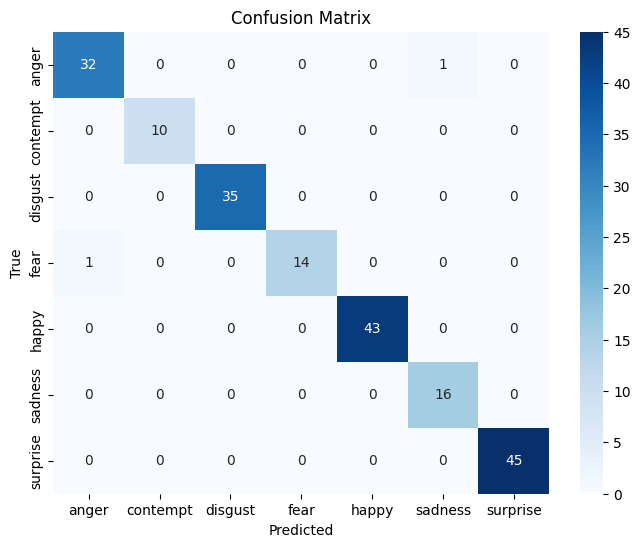

In [28]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 7. Save and Load Model
We save the trained model for later use.

In [29]:
torch.save(model.state_dict(), "emotion_cnn.pth")
model.load_state_dict(torch.load("emotion_cnn.pth"))
model.eval()

EmotionCNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=7, bias=True)
  )
)

## 9. Test on 3 Random Images

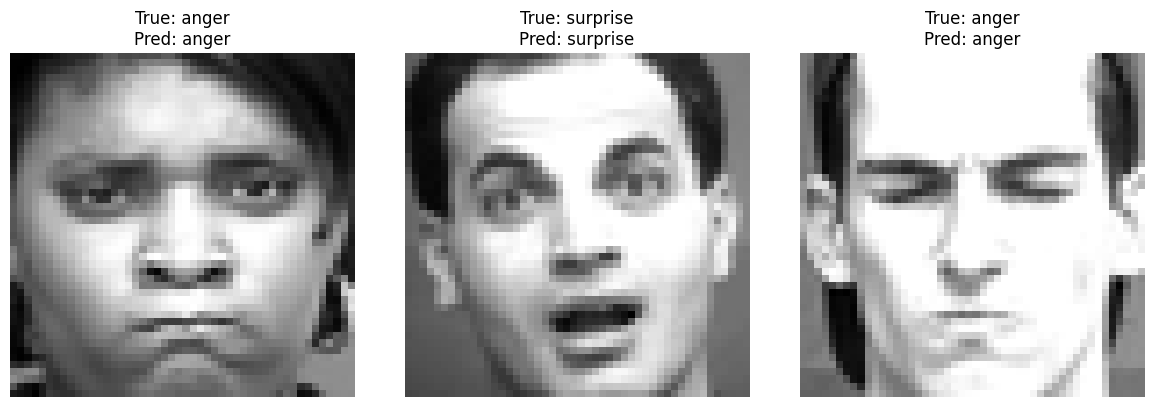

In [30]:
def test_three_random_images(dataset, num_images=3):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, pred = torch.max(output, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze().numpy(), cmap='gray')
        plt.title(f"True: {class_names[label]}\nPred: {class_names[pred.item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

test_three_random_images(val_loader.dataset)

## 10. Show Misclassified Images
This helps identify which expressions are most often confused.

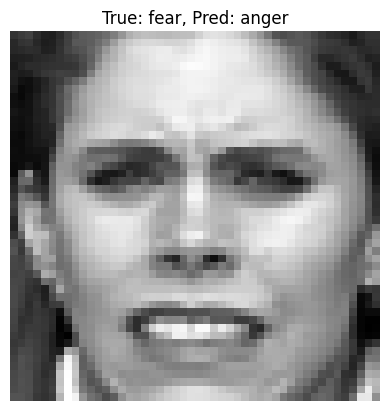

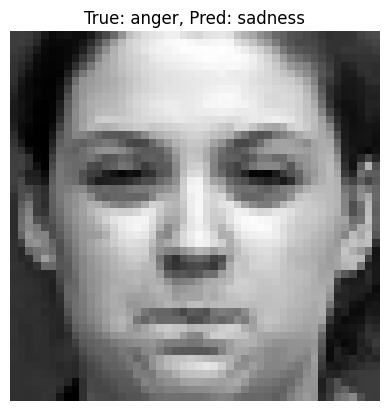

In [31]:
def show_misclassified(dataset, model, max_images=5):
    model.eval()
    shown = 0
    for i in range(len(dataset)):
        image, label = dataset[i]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, pred = torch.max(output, 1)
        if pred.item() != label:
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f"True: {class_names[label]}, Pred: {class_names[pred.item()]}")
            plt.axis('off')
            plt.show()
            shown += 1
            if shown >= max_images:
                break

show_misclassified(val_loader.dataset, model)